# [TPV3] Plotting reference from SEM2DPACK and $se2dr$'s receiverCP file
by JN Hayek (Created on 06.08.2020)



## Library import

In [1]:
import os, sys, math, time

from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0,"/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/LibFolder")
from Lib_GeneralFunctions import *
from Lib_GeneralSignalProcNAnalysis import *
from Lib_ProfilePlotting import *
from Lib_ProfileProcessing import *


#=================== Plotting style ===================
plt.style.use('seaborn-whitegrid')

from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

#definition of colormap
from palettable.scientific.sequential import LaJolla_20
cmap = LaJolla_20.mpl_colormap





In [2]:
# Timestamp variable
start_time = time.time()

In [3]:
# Save into a class the 
class TPV3reference:
    def __init__(self, filename, coordinates, RefSource="SEM2DPACK"):
        
        line = pd.read_csv(filename.format("slip"), header=None)
        self.Time = line[0]
        self.Slip = line[1]
        
        line = pd.read_csv(filename.format("sr"), header=None)
        self.SlipRate = line[1]
        
        self.Coord = coordinates #Only used for labels and 
        self.RefSource = RefSource
    #end __init__
    
    # Default object printing information
    def __repr__(self):
        return "The TPV3reference object was generated from: {} and the receiver is located at {}".format(self.RefSource, self.Coord)
    #end __repr__
    
    def __str__(self):
        return "The TPV3reference object was generated from: {} and the receiver is located at {}".format(self.RefSource, self.Coord)
    #end __str__
    
    def PlotReference(self, ax, SlipSlipRate, filtering=True, **kwargs):
        
        if SlipSlipRate=="Slip":
            if(filtering):
                ax.plot(self.Time, Butterworth(self.Slip, **kwargs), label = "", c = "k", ls = "--", zorder=1)
            else:
                ax.plot(self.Time, self.Slip, label = "", c = "k", ls = "--", zorder=1)
        elif SlipSlipRate=="SlipRate":
            if(filtering):
                ax.plot(self.Time, Butterworth(self.SlipRate, **kwargs), label = "", c = "k", ls = "--", zorder=1)
            else:
                ax.plot(self.Time, self.SlipRate, label = "", c = "k", ls = "--", zorder=1)
            
        return ax

In [4]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/[TPV3]Results/"

# Reference saved into a list of objects
RefList = [TPV3reference(path + "Reference/sem2dpack/sem2d-{}-2.txt", "4km"),
           TPV3reference(path + "Reference/sem2dpack/sem2d-{}-3.txt", "6km"),
           TPV3reference(path + "Reference/sem2dpack/sem2d-{}-4.txt", "8km"),
          ]


RefList = [TPV3reference(path + "Reference/sem2dpack/[TPV3]sem2dpack-{}-receiver-4.0e+03.txt", "4km"),
           TPV3reference(path + "Reference/sem2dpack/[TPV3]sem2dpack-{}-receiver-6.0e+03.txt", "6km"),
           TPV3reference(path + "Reference/sem2dpack/[TPV3]sem2dpack-{}-receiver-8.0e+03.txt", "8km"),
          ]


# Plotting functions for the receiver file from se2dr

In [5]:
def PlotReceiverFile(ax, ReceiverFile, ColIDX, OrderPeriodicity=8, NumReceivers=3, filtering=True, **kwargs):
    ylabeldict={1:"Slip (m)", 2:"Slip Rate (m)", 3:"$\mu$"}
    
    if(filtering):
        SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0])
        [ax.plot(ReceiverFile[0], 
                 Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*i],SamplingFrequency = SamplingFrequency, **kwargs), 
                 zorder=2) for i in range(NumReceivers)]
    else:
        [ax.plot(ReceiverFile[0], ReceiverFile[ColIDX+OrderPeriodicity*i], zorder=2) for i in range(NumReceivers)]
        
    ax.set_ylabel(ylabeldict[ColIDX])
    ax.set_xlabel("time (s)")
    return ax

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.set_xlim(0,7)
        ax.set_ylim(0,7)
        
        
    Lines = fig.axes[-1].get_lines()[-4:]
    
    legend2 = fig.axes[-1].legend(Lines, ['Reference', '4km', '6km', '8km'], loc=1)
    fig.axes[-1].add_artist(legend2)

def GenericFigAxis():
    fig = plt.figure(constrained_layout=True, figsize=[12,4])
    gs = GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    
    return fig, [ax1, ax2]

### Function for plotting 2 sets of graphs (filtered/unfiltered) from a ReceiverCP file

In [6]:
def PlotReceiverCP_wPandas(ReceiverFile, ParamsText, RefList, **kwargs):
    sliporsliprateDict={"Slip":1, "SlipRate": 2}
    
    #================= Plotting Filtered Set ===================#
    fig, axis = GenericFigAxis()
    PlotType = "Slip"
    [item.PlotReference(axis[0], PlotType, filtering=True, **kwargs) for item in RefList] #Reference
    PlotReceiverFile(axis[0], ReceiverFile, sliporsliprateDict[PlotType], filtering = True, **kwargs)

    PlotType = "SlipRate"
    [item.PlotReference(axis[1], PlotType, filtering=True, **kwargs) for item in RefList] #Reference
    PlotReceiverFile(axis[1], ReceiverFile, sliporsliprateDict[PlotType], filtering = True, **kwargs)

    format_axes(fig)
    
    if "CutoffFrequency" in kwargs:
        fig.suptitle("[TPV3] Filtered results ($f_c=${}$Hz$) {}".format(kwargs.get("CutoffFrequency"),ParamsText))
    else:
        fig.suptitle("[TPV3] Filtered results ($f_c=7Hz$) {}".format(ParamsText))

    #================= Plotting Non-Filtered Set ===================#
    fig, axis = GenericFigAxis()

    PlotType = "Slip"
    [item.PlotReference(axis[0], PlotType, filtering=False) for item in RefList] #Reference
    PlotReceiverFile(axis[0], ReceiverFile, sliporsliprateDict[PlotType], filtering = False)

    PlotType = "SlipRate"
    [item.PlotReference(axis[1], PlotType, filtering=False) for item in RefList] #Reference
    PlotReceiverFile(axis[1], ReceiverFile, sliporsliprateDict[PlotType], filtering = False)

    format_axes(fig)
    fig.suptitle("[TPV3] Unfiltered results {}".format(ParamsText))
    

### TPV3 Plots (P1, P2 - No blending function added)

AttributeError: Unknown property cmap

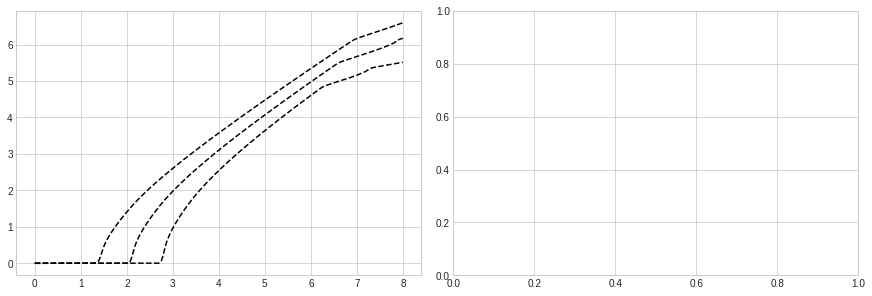

In [7]:
ReceiverFile = pd.read_csv(path+"20200807/receiverCP-dr-2400x2400-p1.dat", 
                           comment = '#',header = None, delimiter = " ")
ParamsText = "\np = 1, dx=25m, $\delta=25.025$m" 

PlotReceiverCP_wPandas(ReceiverFile, ParamsText, RefList)

In [ ]:
ReceiverFile = pd.read_csv(path+"20200807/receiverCP-dr-2400x2400-p2.dat", 
                           comment = '#',header = None, delimiter = " ")
ParamsText = "\np = 2, dx=25m, $\delta=25.025$m" 

PlotReceiverCP_wPandas(ReceiverFile, ParamsText, RefList)

# Error Analysis
## Get the difference in timing and max value of the peak in the peak slip rate

There must be a function that uses a pair [time, PeakValue] generated from one of the reference files to substract from the pair [time, PeakValue] generated from a specific station.

- Remember that all stations reside in a file, in different columns for the output of se2dr, while all stations are separated in the output of SEM2DPACK
- Consider cases filtered vs non-filtered
- Timing vs Difference in magnitue of the peak slip rate
- The data from different stations are tied with a line. (Consider the case where we only tie by a line equal station, different p refinement value)

For the Last case, it would be good to build a Pandas DataFrame, Where the value of p, h, location of the station, Timing Difference, Slip rate Magnitude difference are saved 

In [ ]:
def GetMaxPeakValueNTiming_FromLists(TimeList,MagnList):
        idx = MagnList.index(max(MagnList))
        
        PeakValue = MagnList[idx]
        PeakTiming = TimeList[idx]
        
        return [PeakTiming,PeakValue]
    
def GetDictDataReceiver(p, dx, ReceiverLoc, RefPair,ReceiverPair):
    ToAppendDict={"p": p,
                  "dx":  dx,
                  "ReceiverLoc": ReceiverLoc,
                  "TimingDifference": ReceiverPair[0]-RefPair[0], 
                  "SlipRateDifference":ReceiverPair[1]-RefPair[1]
                 }
    return ToAppendDict

def PlotnScatter3Lists(axis,x,y,z):
    axis.scatter(x, y)
    axis.plot(x, y)
    for i, txt in enumerate(z):
        axis.annotate(txt, (x[i], y[i]))

### Non-filtered extraction of differences

In [ ]:
Data = pd.DataFrame(columns=["p","dx", "ReceiverLoc", "TimingDifference", "SlipRateDifference"])

for NumReceiver in range(3):
    
    # Get the reference Pair
    RefItem = RefList[NumReceiver]; print(RefItem)
    RefPair = GetMaxPeakValueNTiming_FromLists(RefItem.Time.tolist(),
                                               RefItem.SlipRate.tolist())
    
    # Get the receiver Pair for p = 1 =====================================================
    ReceiverFile = pd.read_csv(path+"20200807/receiverCP-dr-2400x2400-p1.dat", 
                               comment = '#',header = None, delimiter = " ")
    ColIDX=2; OrderPeriodicity = 8 #; NumReceiver= 0;  Order in the file ReceiverCP: numReceiver 0 = 4km, 1 = 6km, 2 = 8km

    ReceiverPair = GetMaxPeakValueNTiming_FromLists(ReceiverFile[0].tolist(), 
                                                    ReceiverFile[ColIDX+OrderPeriodicity*NumReceiver].tolist())

    ToAppendDict = GetDictDataReceiver(1, "25m", RefItem.Coord, RefPair, ReceiverPair)
    Data = Data.append(ToAppendDict, ignore_index=True)
    
    
    # Get the receiver Pair for p = 2 =====================================================
    ReceiverFile = pd.read_csv(path+"20200807/receiverCP-dr-2400x2400-p2.dat", 
                               comment = '#',header = None, delimiter = " ")
    ColIDX=2; OrderPeriodicity = 8 #; NumReceiver= 0;  Order in the file ReceiverCP: numReceiver 0 = 4km, 1 = 6km, 2 = 8km

    ReceiverPair = GetMaxPeakValueNTiming_FromLists(ReceiverFile[0].tolist(), 
                                                    ReceiverFile[ColIDX+OrderPeriodicity*NumReceiver].tolist())

    ToAppendDict = GetDictDataReceiver(2, "25m", RefItem.Coord, RefPair, ReceiverPair)
    Data = Data.append(ToAppendDict, ignore_index=True)

In [ ]:
Data

In [ ]:
p1Data = Data[Data.p == 1]
p2Data = Data[Data.p == 2]

fig,axis=GenericFigAxis()

PlotnScatter3Lists(axis[0], 
                   p1Data.TimingDifference.tolist(),
                   p1Data.SlipRateDifference.tolist(),
                   p1Data.ReceiverLoc.tolist())
PlotnScatter3Lists(axis[0], 
                   p2Data.TimingDifference.tolist(),
                   p2Data.SlipRateDifference.tolist(),
                   p2Data.ReceiverLoc.tolist())

rec1Data = Data[Data.ReceiverLoc == "4km"]
rec2Data = Data[Data.ReceiverLoc == "6km"]
rec3Data = Data[Data.ReceiverLoc == "8km"]

PlotnScatter3Lists(axis[1], 
                   rec1Data.TimingDifference.tolist(),
                   rec1Data.SlipRateDifference.tolist(),
                   rec1Data.p.tolist())

PlotnScatter3Lists(axis[1], 
                   rec2Data.TimingDifference.tolist(),
                   rec2Data.SlipRateDifference.tolist(),
                   rec2Data.p.tolist())

PlotnScatter3Lists(axis[1], 
                   rec3Data.TimingDifference.tolist(),
                   rec3Data.SlipRateDifference.tolist(),
                   rec3Data.p.tolist())

#=========================================================
# Lines Formatting axis 0
Lines = axis[0].get_lines()
legend2 = axis[0].legend(Lines, ['p = 1', 'p = 2'])
axis[0].add_artist(legend2)

# Lines Formatting axis 1
Lines = axis[1].get_lines()
legend2 = axis[1].legend(Lines, ['4 km', '6 km', '8 km'])
axis[1].add_artist(legend2)

for ax in axis:
    ax.set_xlabel("Timing Difference (s)")
    ax.set_ylabel("Peak slip rate Difference (m/s)")
fig.suptitle("Timing and peak slip rate difference wrt. SEM2DPACK reference \n non-filtered")

### Filtered extraction of differences

In [ ]:
Data = pd.DataFrame(columns=["p","dx", "ReceiverLoc", "TimingDifference", "SlipRateDifference"])

CutoffFreq=7

for NumReceiver in range(3):
    
    # Get the reference Pair
    RefItem = RefList[NumReceiver]; print(RefItem)
    RefPair = GetMaxPeakValueNTiming_FromLists(RefItem.Time.tolist(),
                                               Butterworth(RefItem.SlipRate.tolist(),
                                                           CutoffFrequency = CutoffFreq)
                                              )
    
    # Get the receiver Pair for p = 1 =====================================================
    ReceiverFile = pd.read_csv(path+"20200807/receiverCP-dr-2400x2400-p1.dat", 
                               comment = '#',header = None, delimiter = " ")
    ColIDX=2; OrderPeriodicity = 8 #; NumReceiver= 0;  Order in the file ReceiverCP: numReceiver 0 = 4km, 1 = 6km, 2 = 8km
    
    ReceiverPair = GetMaxPeakValueNTiming_FromLists(ReceiverFile[0].tolist(), 
                                                    Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*NumReceiver].tolist(),
                                                                SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0]),
                                                                CutoffFrequency = CutoffFreq)
                                                   )

    ToAppendDict = GetDictDataReceiver(1, "25m", RefItem.Coord, RefPair, ReceiverPair)
    Data = Data.append(ToAppendDict, ignore_index=True)
    
    
    # Get the receiver Pair for p = 2 =====================================================
    ReceiverFile = pd.read_csv(path+"20200807/receiverCP-dr-2400x2400-p2.dat", 
                               comment = '#',header = None, delimiter = " ")
    ColIDX=2; OrderPeriodicity = 8 #; NumReceiver= 0;  Order in the file ReceiverCP: numReceiver 0 = 4km, 1 = 6km, 2 = 8km
    
    ReceiverPair = GetMaxPeakValueNTiming_FromLists(ReceiverFile[0].tolist(), 
                                                    Butterworth(ReceiverFile[ColIDX+OrderPeriodicity*NumReceiver].tolist(),
                                                                SamplingFrequency = 1./(ReceiverFile[0][1]-ReceiverFile[0][0]),
                                                                CutoffFrequency = CutoffFreq)
                                                   )

    ToAppendDict = GetDictDataReceiver(2, "25m", RefItem.Coord, RefPair, ReceiverPair)
    Data = Data.append(ToAppendDict, ignore_index=True)
    
p1Data = Data[Data.p == 1]
p2Data = Data[Data.p == 2]

fig,axis=GenericFigAxis()

PlotnScatter3Lists(axis[0], 
                   p1Data.TimingDifference.tolist(),
                   p1Data.SlipRateDifference.tolist(),
                   p1Data.ReceiverLoc.tolist())
PlotnScatter3Lists(axis[0], 
                   p2Data.TimingDifference.tolist(),
                   p2Data.SlipRateDifference.tolist(),
                   p2Data.ReceiverLoc.tolist())

rec1Data = Data[Data.ReceiverLoc == "4km"]
rec2Data = Data[Data.ReceiverLoc == "6km"]
rec3Data = Data[Data.ReceiverLoc == "8km"]

PlotnScatter3Lists(axis[1], 
                   rec1Data.TimingDifference.tolist(),
                   rec1Data.SlipRateDifference.tolist(),
                   rec1Data.p.tolist())

PlotnScatter3Lists(axis[1], 
                   rec2Data.TimingDifference.tolist(),
                   rec2Data.SlipRateDifference.tolist(),
                   rec2Data.p.tolist())

PlotnScatter3Lists(axis[1], 
                   rec3Data.TimingDifference.tolist(),
                   rec3Data.SlipRateDifference.tolist(),
                   rec3Data.p.tolist())

#=========================================================
# Lines Formatting axis 0
Lines = axis[0].get_lines()
legend2 = axis[0].legend(Lines, ['p = 1', 'p = 2'])
axis[0].add_artist(legend2)

# Lines Formatting axis 1
Lines = axis[1].get_lines()
legend2 = axis[1].legend(Lines, ['4 km', '6 km', '8 km'])
axis[1].add_artist(legend2)

for ax in axis:
    ax.set_xlabel("Timing Difference (s)")
    ax.set_ylabel("Peak slip rate Difference (m/s)")
fig.suptitle("Timing and peak slip rate difference wrt. SEM2DPACK reference \n  low-pass Butterworth filter ($f_c=${}$Hz$)".format(CutoffFreq))